In [1]:
from xclib.data import data_utils
import pandas as pd
import numpy as np
from numpy import log2 as log
from collections import Counter, OrderedDict
from scipy.stats import mode
import time
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from datetime import datetime
import copy

In [2]:
#TrainData = data_utils.read_sparse_file('data/train_x.txt', force_header = True, dtype="float32")

TrainData = pd.read_csv("data/train_x.csv", header = None, dtype = np.int32)
TrainLabels = pd.read_csv("data/train_y.csv", header = None, dtype = np.int32)
TrainData['labels'] = TrainLabels
print(Counter(TrainData.labels))

ValData = pd.read_csv("data/valid_x.csv", header = None, dtype = np.int32)
ValLabels = pd.read_csv("data/valid_y.csv", header = None, dtype = np.int32)
ValData['labels'] = ValLabels
print(Counter(ValData.labels))

TestData = pd.read_csv("data/test_x.csv", header = None, dtype = np.int32)
TestLabels = pd.read_csv("data/test_y.csv", header = None, dtype = np.int32)
TestData['labels'] = TestLabels
print(Counter(TestData.labels))

Counter({1: 34153, 0: 30560})
Counter({1: 11270, 0: 10302})
Counter({1: 11420, 0: 10151})


In [3]:
Nodes = []
Tree = {}

In [4]:
PrunedNodes = []
PrunedList = []
TestAccuracy = []
ValAccuracy = []
TrainAccuracy = []

prunedTestAccuracy = []
prunedValAccuracy = []
prunedTrainAccuracy = []

In [14]:
def splitByMedian(d):
    '''
    This function splits the array for values > median and <= median.
    Returns array of Boolean: True if value > median else False
    '''
    colMedian = np.median(d)
    
    boolArr = (d > colMedian)
    return boolArr

def calcEntropy(y):
    '''
    Calculate and return entropy based on class labels.
    '''
    val, counts = np.unique(y, return_counts=True)
    prob = counts.astype('float')/len(y)
    en = 0
    for v in prob:
        if v != 0.0:
            en -= v * log(v)
            
    return en

def calcMI(data):
    '''
    Calculates Mututal Information for the given rows of data splitting it by each attribute one by one.
    Returns Best Attribute with Maximum Information Gain
    '''
    MIList = []    
    rows, cols = data.shape
    for i in range(cols - 1):
        posArr = splitByMedian(data[:,i])
        enNode = calcEntropy(data[:,-1])
        probPos = Counter(posArr)[True]/len(posArr)
        probNeg = 1- probPos         
        
        entropyPos = calcEntropy(data[:, -1][posArr])
        entropyNeg = calcEntropy(data[:, -1][np.logical_not(posArr)])

        MI = enNode - ((probPos * entropyPos) + (probNeg * entropyNeg))
        MIList.append(MI)
    return np.argmax(MIList)

def getBestAttribute(data):
    '''
    Calculates and return Best Attrubute to split at a given node, and corresponding median value to split
    and list of left and right child
    '''
    bestAttr = calcMI(data)    
    attrMedian = np.median(data[:,bestAttr])
    children = []
    
    rightArr = (data[:,bestAttr] > attrMedian)
    leftArr = np.logical_not(rightArr)
    
    children.append(data[leftArr])
    children.append(data[rightArr])
    
    return bestAttr, attrMedian, children


class Node:
    '''Node class'''
    def __init__(self, index, parent):
        
        self.index = index 
        self.parent = parent
        self.number = 0
        self.children = 0
        self.left = None
        self.right = None
        self.splitAttr = None
        self.splitValue = None
        self.majorityClass = None
        self.total = 0
        self.positive = 0
        
        
    def __repr__(self):
        if self.children == 2:
            R = (self.index,  self.number, self.parent, self.children, self.right, self.left, self.splitAttr, self.splitValue, self.majorityClass, self.total, self.positive)
            toReturn = "<Node: index=%r, number=%r, parent=%r, children=%r, right=%r, left=%r, splitAttr=%r, splitValue=%r, majorityClass=%r, total=%r, positive=%r >" % R
        else:
            R = (self.index, self.number, self.parent, self.children, self.majorityClass, self.total, self.positive)
            toReturn = "<Leaf: index=%r, number=%r, parent=%r, children=%r, majorityClass=%r, total=%r, positive=%r >" % R
            
        return toReturn
    
def isLeaf(lbls):
    '''
    if all labels are of same class then declare it a Leaf Node
    '''
    ctr = Counter(lbls)
    if len(ctr) < 2:
        return True
    return False
    
def growTree(data, parentIdx):
    '''
    Grow Tree Recursively
    '''
    nodeData = data
    
    if len(nodeData) == 0:
        return None
    
    node = Node(len(Nodes), parentIdx)
    node.majorityClass = mode(nodeData[:,-1])[0][0]
    
    
    if isLeaf(nodeData[:, -1]):
        Nodes.append(node)
        return node.index
    
    bestAttr, attrMedian, children = getBestAttribute(nodeData)
    
    node.splitAttr = bestAttr
    node.splitValue = attrMedian
    node.children = len(children)
    
    
    if len(children[1]) == 0:
        node.children = 1
        Nodes.append(node)
        return node.index
    
    Nodes.append(node)
    #print(node)
    for i in range(len(children)):
        idx = growTree(children[i], node.index)
        
        if node.index not in Tree:
            Tree[node.index] = {}
        Tree[node.index][i] = idx
        if i == 0:
            node.left = Nodes[idx] 
        else:
            node.right = Nodes[idx]
    
    return node.index


def breadthFirstTraversal(rootNode):
    '''
    Breadth Firest Traversal of tree to assign nodes number in sequence is BFS order
    '''
    count = 1
    NodeToVisit = [rootNode]
    TN = 0
    
    while NodeToVisit:
        currentNode = NodeToVisit.pop(0)
        #print(currentNode)
        currentNode.number = count
        count += 1
        if currentNode.children == 2:
            NodeToVisit.append(currentNode.left)
            NodeToVisit.append(currentNode.right)
        
    return count

def predict(node, x, maxNodes):
    '''
    Predict labels for new data point
    '''
    if(node.children != 2):
        return node.majorityClass
    
    if x[node.splitAttr] > node.splitValue:
        if node.right.number >= maxNodes:
            return node.majorityClass
        else:
            return predict(node.right, x, maxNodes)
        
    if x[node.splitAttr] <= node.splitValue:
        if node.left.number >= maxNodes:
            return node.majorityClass
        else:
            return predict(node.left, x, maxNodes)
        
        
    
def getAccuracy(data, labels, dataType):
    if(dataType == "Test"):
        TestAccuracy.clear()
    elif(dataType == "Val"):
        ValAccuracy.clear()
    elif(dataType == "Train"):
        TrainAccuracy.clear()
    
    for maxNodes in range(1, len(Nodes), 100):
        prediction = []
        #print(maxNodes)
        for i in range(len(data)):            
            prediction.append(predict(Nodes[0], data[i], maxNodes))
        
        accuracy = accuracy_score(labels, prediction)
        if(dataType == "Test"):
            TestAccuracy.append(accuracy)
        elif(dataType == "Val"):
            ValAccuracy.append(accuracy)
        elif(dataType == "Train"):
            TrainAccuracy.append(accuracy)
            #print(TrainAccuracy[-1])
    return 

def getAllAccuracy():
    totalNodes = breadthFirstTraversal(Nodes[0])
    
    t0 = time.time()
    print("\nCalculating Accuracy for Train Data")
    getAccuracy(Train_X, Train_Y,"Train")
    print("\nCalculating Accuracy for Validation Data")
    getAccuracy(Val_X, Val_Y, "Val")
    print("\nCalculating Accuracy for Test Data")
    getAccuracy(Test_X, Test_Y, "Test")
    
    t1 = time.time()
    print("Time take for prediction = {}Mins".format(round((t1-t0)/60, 3)))
    
    return totalNodes

def plotAccuracies(nodes, treeType):
    if treeType == "full":
        TrA = TrainAccuracy
        VaA = ValAccuracy
        TeA = TestAccuracy
    elif treeType == "pruned":
        TrA = prunedValAccuracy
        VaA = prunedTrainAccuracy
        TeA = prunedTestAccuracy
        
    fig = plt.figure(0)
    xAxis = [i for i in range(0, nodes, 100)]
    plt.plot(xAxis, 100*np.array(TrA), label="Train Accuracy")
    plt.plot(xAxis, 100*np.array(VaA), c="tab:green", label="Validation Accuracy")
    plt.plot(xAxis, 100*np.array(TeA), c="tab:orange", label="Test Accuracy")
    plt.title("Accuracy vs Number of Nodes")
    plt.xlabel("Number of Nodes")
    plt.ylabel("% Accuracy")
    plt.legend()
    plt.show()
    fig.savefig("plots/q_a_{}.png".format(treeType), dpi= 300, pad_inches=0.1, format="png")
    return

def calcAndPlotAccuracies():
    totalNodes = getAllAccuracy()
    plotAccuracies(totalNodes, "full")
    
    return
                
def deleteSubtreeNodes(node):
    '''
    insert value = "Pruned" for pruned subtree nodes
    to keep a count of existing nodes after pruning
    '''
    if node.children != 2:
        PrunedNodes[node.index] = "Pruned"
        PrunedList.append(node.index)
        return
    #PrunedNodes[node.index] = "Pruned"
    #PrunedList.append(node.index)
    
    if node.left != None:
        deleteSubtreeNodes(node.left)
        
    if node.right != None:
        deleteSubtreeNodes(node.right)
        
def postPruneTree(node):
    '''
    Post Prune Tree for a given node
    '''
    if node.children != 2:
        return int(node.total - node.positive) if node.majorityClass == 1 else int(node.positive)
    
    else:
        errorRightSubtree = postPruneTree(node.right)
        errorLeftSubtree = postPruneTree(node.left)
        #print(errorLeftSubtree, errorRightSubtree)
        nodeError = errorLeftSubtree + errorRightSubtree
        
        if nodeError < min(node.positive, node.total - node.positive):
            return nodeError
        else:
            #make this node a leaf node with Majority as msjotiyClass
            deleteSubtreeNodes(node) #delete subtree nodes for Nodes List
            node.children = 0
            node.left = node.right = None            
            
            if node.positive >= node.total - node.positive:
                node.majorityClass = 1
                return node.total - node.positive
            else:
                node.majorityClass = 0
                return node.positive
                
            

            

def classifySubtree(node, x, y):
    '''
    Update node.total and node.positive objects
    '''
    node.total += 1
    if y == 1:
        node.positive += 1        
        
    if node.children == 2: #not leaf node
        if x[node.splitAttr] > node.splitValue:
            classifySubtree(node.right, x, y)
        else:
            classifySubtree(node.left, x, y)
    
    
        
def runReducedErrorPruning(node, X, Y):
    '''
    Running Reduced Error Post Pruning Algorithm
    Reference: https://arxiv.org/pdf/1106.0668.pdf as Mentioned by TA
    Param: 
    node = Root Node
    X = Validation Set
    '''
    for i in range(len(X)):
        classifySubtree(node, X[i], Y[i])
    #print(node)
    postPruneTree(node)
    return        
        
        
    
def getAccuracyPruned(data, labels, dataType, tNodes):
    if(dataType == "Test"):
        prunedTestAccuracy.clear()
    elif(dataType == "Val"):
        prunedValAccuracy.clear()
    elif(dataType == "Train"):
        prunedTrainAccuracy.clear()
    
    for maxNodes in range(1, tNodes, 100):
        prediction = []
        #print(maxNodes)
        for i in range(len(data)):            
            prediction.append(predict(PrunedTree, data[i], maxNodes))
        
        accuracy = accuracy_score(labels, prediction)
        if(dataType == "Test"):
            prunedTestAccuracy.append(accuracy)
        elif(dataType == "Val"):
            prunedValAccuracy.append(accuracy)
        elif(dataType == "Train"):
            prunedTrainAccuracy.append(accuracy)
            #print(TrainAccuracy[-1])
    return 

def getAllAccuracyPruned():
    totalNodes = breadthFirstTraversal(PrunedTree)
    ct = 0
    for each in PrunedNodes:
        if each == "Pruned":
            ct += 1
            
    totalNodes = len(Nodes) - ct
    
    t0 = time.time()
    print("\nCalculating Accuracy for Train Data")
    getAccuracyPruned(Train_X, Train_Y, "Train", totalNodes)
    print("\nCalculating Accuracy for Validation Data")
    getAccuracyPruned(Val_X, Val_Y, "Val", totalNodes)
    print("\nCalculating Accuracy for Test Data")
    getAccuracyPruned(Test_X, Test_Y, "Test", totalNodes)
    
    t1 = time.time()
    print("Time take for prediction = {}Mins".format(round((t1-t0)/60, 3)))
    
    return totalNodes
        
def calcAndPlotAccuraciesPruned():
    totalNodes = getAllAccuracyPruned()
    plotAccuracies(totalNodes, "pruned")    
            

In [6]:
Train_X = TrainData.to_numpy()[:,:-1]
Train_Y = TrainData.to_numpy()[:,-1]

Val_X = ValData.to_numpy()[:,:-1]
Val_Y = ValData.to_numpy()[:,-1]

Test_X = TestData.to_numpy()[:,:-1]
Test_Y = TestData.to_numpy()[:,-1]


@@@@@@@*****Q1_a*****@@@@@@@

Start Time = 20:38:25
Time to grow tree = 11.65Mins
Total Number of Nodes = 19987

Calculating Accuracy for Train Data

Calculating Accuracy for Validation Data

Calculating Accuracy for Test Data
Time take for prediction = 27.88Mins


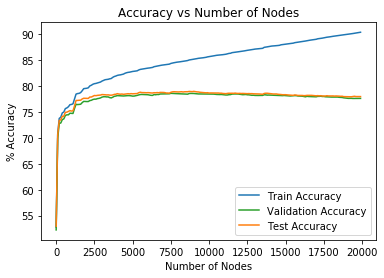


@@@@@@@*****Q1_b*****@@@@@@@

Pruning Begins at:  21:17:57

Calculating Accuracy for Train Data

Calculating Accuracy for Validation Data

Calculating Accuracy for Test Data
Time take for prediction = 5.382Mins


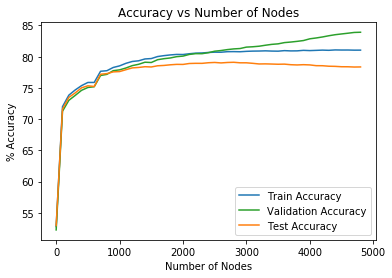

In [7]:
print("\n@@@@@@@*****Q1_a*****@@@@@@@\n")

Nodes.clear()
Tree.clear()
t0 = time.time()
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
growTree(TrainData.to_numpy(), "Root")
t1 = time.time()

print("Time to grow tree = {}Mins".format(round((t1-t0)/60,2)))
print("Total Number of Nodes =", len(Nodes))

calcAndPlotAccuracies()

print("\n@@@@@@@*****Q1_b*****@@@@@@@\n")
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Pruning Begins at: ", current_time)

PrunedNodes = copy.deepcopy(Nodes)
PrunedTree = copy.deepcopy(Nodes[0])
runReducedErrorPruning(PrunedTree, Val_X, Val_Y)

calcAndPlotAccuraciesPruned()


Calculating Accuracy for Train Data

Calculating Accuracy for Validation Data

Calculating Accuracy for Test Data
Time take for prediction = 6.877Mins


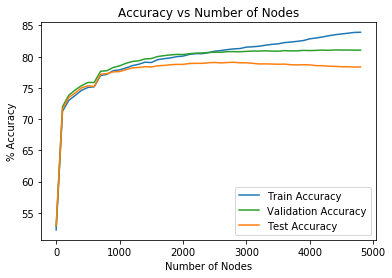

In [15]:
calcAndPlotAccuraciesPruned()

In [13]:
print("\n######---Before Pruning---######\n")
print("Max Train Accuracy = {}% for argmax {} Nodes".format(100*max(TrainAccuracy), 100*np.argmax(TrainAccuracy)))
print("Max Validation Accuracy = {}% for argmax {} Nodes".format(100*max(ValAccuracy), 100*np.argmax(ValAccuracy)))
print("Max Test Accuracy = {}% for argmax {} Nodes".format(100*max(TestAccuracy), 100*np.argmax(TestAccuracy)))

print("\nTrain Accuracy for full grown tree = {}% ".format(100*TrainAccuracy[-1]))
print("Validation Accuracy for full grown tree = {}% ".format(100*ValAccuracy[-1]))
print("Test Accuracy for full grown tree = {}% ".format(100*TestAccuracy[-1]))

print("\n######---Post Pruning---######\n")
print("Max Train Accuracy = {}% for argmax {} Nodes".format(100*max(prunedTrainAccuracy), 100*np.argmax(prunedTrainAccuracy)))
print("Max Validation Accuracy = {}% for argmax {} Nodes".format(100*max(prunedValAccuracy), 100*np.argmax(prunedValAccuracy)))
print("Max Test Accuracy = {}% for argmax {} Nodes".format(100*max(prunedTestAccuracy), 100*np.argmax(prunedTestAccuracy)))

print("\nTrain Accuracy for Pruned full grown tree = {}% ".format(100*prunedTrainAccuracy[-1]))
print("Validation Accuracy for Pruned full grown tree = {}% ".format(100*prunedValAccuracy[-1]))
print("Test Accuracy for full Pruned grown tree = {}% ".format(100*prunedTestAccuracy[-1]))


######---Before Pruning---######

Max Train Accuracy = 90.40841871030551% for argmax 19900 Nodes
Max Validation Accuracy = 78.61579825699981% for argmax 7500 Nodes
Max Test Accuracy = 78.99494691947521% for argmax 9000 Nodes

Train Accuracy for full grown tree = 90.40841871030551% 
Validation Accuracy for full grown tree = 77.63767847209346% 
Test Accuracy for full grown tree = 77.9843308145195% 

######---Post Pruning---######

Max Train Accuracy = 81.08108108108108% for argmax 4400 Nodes
Max Validation Accuracy = 83.91433339514185% for argmax 4800 Nodes
Max Test Accuracy = 79.10157155440174% for argmax 2800 Nodes

Train Accuracy for Pruned full grown tree = 81.04708482066972% 
Validation Accuracy for Pruned full grown tree = 83.91433339514185% 
Test Accuracy for full Pruned grown tree = 78.3551991099161% 


In [ ]:
PrunedNodes = copy.deepcopy(Nodes)
PrunedTree = copy.deepcopy(Nodes[0])
runReducedErrorPruning(PrunedTree, Val_X, Val_Y)
calcAndPlotAccuraciesPruned()

In [ ]:
len(np.unique(PrunedList, return_counts=False))

In [ ]:
def postPruneTree(node):
    '''
    Post Prune Tree for a given node
    '''
    if node.children != 2:
        return int(node.total - node.positive) if node.majorityClass == 1 else int(node.positive)
    
    else:
        errorRightSubtree = postPruneTree(node.right)
        errorLeftSubtree = postPruneTree(node.left)
        #print(errorLeftSubtree, errorRightSubtree)
        nodeError = errorLeftSubtree + errorRightSubtree
        
        if nodeError < min(node.positive, node.total - node.positive):
            return nodeError
        else:
            #make this node a leaf node with Majority as msjotiyClass
            
            node.children = 0
            node.left = node.right = None            
            
            if node.positive >= node.total - node.positive:
                node.majorityClass = 1
                return node.total - node.positive
            else:
                node.majorityClass = 0
                return node.positive
                
            deleteSubtreeNodes(node) #delete subtree nodes for Nodes List
                
def deleteSubtreeNodes(node):
    '''
    insert value = "Pruned" for pruned subtree nodes
    to keep a count of existing nodes after pruning
    '''
    if node.children != 2:
        PrunedNodes[node.index] = "Pruned"
        return
    PrunedNodes[node.index] = "Pruned"
    
    if node.left != None:
        deleteSubtreeNodes(node.left)
        
    if node.right != None:
        deleteSubtreeNodes(node.right)
            

def classifySubtree(node, x, y):
    '''
    Update node.total and node.positive objects
    '''
    node.total += 1
    if y == 1:
        node.positive += 1        
        
    if node.children == 2: #not leaf node
        if x[node.splitAttr] > node.splitValue:
            classifySubtree(node.right, x, y)
        else:
            classifySubtree(node.left, x, y)
    
    
        
def runReducedErrorPruning(node, X, Y):
    '''
    Running Reduced Error Post Pruning Algorithm
    Reference: https://arxiv.org/pdf/1106.0668.pdf as Mentioned by TA
    Param: 
    node = Root Node
    X = Validation Set
    '''
    for i in range(len(X)):
        classifySubtree(node, X[i], Y[i])
    #print(node)
    postPruneTree(node)
    return 

In [ ]:
breadthFirstTraversal(PrunedTree)

In [ ]:
Nodes.clear()
Tree.clear()
t0 = time.time()
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
growTree(TrainData.to_numpy(), "Root")
t1 = time.time()

print("Time to grow tree = {}Mins".format(round((t1-t0)/60,2)))
print("Total Number of Nodes =", len(Nodes))


In [ ]:
getAllAccuracy()
plotAccuracies()


In [ ]:
plotAccuracies()

In [ ]:
count = []
def height(root):
    count.append(1)
    if root not in Tree:
        return 0

    ans = 0
    for key in Tree[root]:
        x = height(Tree[root][key])
        if x > ans:
            ans = x
    return ans + 1

def breadthFirstTraversal(rootIdx):
    count = 1
    NodeToVisit = [rootIdx]
    while NodeToVisit:
        currentNode = NodeToVisit.pop(0)
        #print(currentNode)
        Nodes[currentNode].number = count
        count += 1
        if currentNode in Tree:
            NodeToVisit.append(Tree[currentNode][0])
            NodeToVisit.append(Tree[currentNode][1])
        


In [ ]:
ct = 0
for each in PrunedNodes:
    if each == "Pruned":
        ct += 1
    
print(ct)

In [ ]:
19987 - 15221

In [ ]:
Counter(Val_Y)

In [ ]:
z = [i for i in range(0, 19987, 100)]
plt.plot(z , z)